In [1]:
from multiprocessing import Pool,Process,Manager,cpu_count
import math
import numpy as np
import pylab
import time
from pathlib import Path
import numpy as np
from PyBoltz.PyBoltzRun import *
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data


def Plotabble(Files,Skip,isReduceField=False,IndexFromData=False,vsize=10):
    
    ### Structure
    # Efield --> 1atm to 10atm
    
    Efield_dic={}
    values=PickleITRead(Files)
    if("Efields" in values and "Pressures" in values ):
        if(len(values["Efields"])!=0 and len(values["Pressures"])!=0 ):
            Simulated_dic={}
            Pressure=np.array(values["Efields"])
            Simulated_dic["Efields"]=values["Efields"]
            Simulated_dic["Pressures"]=values["Pressures"]
            vsize=len(values["Pressures"])


    VectorSize=vsize-Skip
    idx=0
    tempPressure=0
    
    for key,value in values.items():
        
        if(key=="Efields" or key=="Pressures"):
            continue
        Splitted=key.split("_")
        
        fVel=float(value["Drift_vel"][0])
        fVelError=float(value["Drift_vel"][1])
        fDT=float(value["DT"][0])
        fDTError=float(value["DT"][1])
        
        fDL=float(value["DL"][0])
        fDLError=float(value["DL"][1])
        
        if("DT1" in value):
            fDT1=float(value["DT1"][0])
            fDTError1=float(value["DT1"][1])

            fDL1=float(value["DL1"][0])
            fDLError1=float(value["DL1"][1])
        
        
        Pressure=round(float(Splitted[1]))    
        Efield=round(float(Splitted[0]))
        
        if(IndexFromData):
            idx=round(float(Splitted[1])*0.00133322)
        else:
            if(tempPressure!=Pressure):
                idx=idx+1
                tempPressure=Pressure
            
        if(Skip):
            Index=idx-1-Skip
            if(Index<0): continue
        else:
            Index=idx-1
            
            

        #print(f"Index -->> {Index}")
        #print(f"Electric Field -->> {Efield}")
        #print(f"Pressure -->> {Pressure}")

        if(Efield in Efield_dic):
            Efield_dic[Efield]["Drift_vel"][0][Index]=fVel
            Efield_dic[Efield]["Drift_vel"][1][Index]=fVelError
            Efield_dic[Efield]["DT"][0][Index]=fDT
            Efield_dic[Efield]["DT"][1][Index]=fDTError
            Efield_dic[Efield]["DL"][0][Index]=fDL
            Efield_dic[Efield]["DL"][1][Index]=fDLError
            
            if(isReduceField):
                Efield_dic[Efield]["ReducedField"][Index]=Efield/(Index+1)
            
            if("DT1" in value):
                Efield_dic[Efield]["DT1"][0][Index]=fDT1
                Efield_dic[Efield]["DT1"][1][Index]=fDTError1
                Efield_dic[Efield]["DL1"][0][Index]=fDL1
                Efield_dic[Efield]["DL1"][1][Index]=fDLError1


        else:
         

            SingleValue_dict={}
            # Drift Velocity array
            DriftVelocity=np.zeros(VectorSize)
            DriftVelError=np.zeros(VectorSize)
            
            # Transverse Diffusion
            DT=np.zeros(VectorSize)
            DTError=np.zeros(VectorSize)

            #Longotituonal Diffusion
            DL=np.zeros(VectorSize)
            DLError=np.zeros(VectorSize)
            ReducedField=np.zeros(VectorSize)
            
            ## Insert values
            DriftVelocity[Index]=fVel
            DriftVelError[Index]=fVelError
            DT[Index]=fDT
            DTError[Index]=fDTError
            DL[Index]=fDL
            DLError[Index]=fDLError
            if(isReduceField):
                ReducedField[Index]=Efield/(Index+1)
            
            if("DT1" in value):
                DL1=np.zeros(VectorSize)
                DLError1=np.zeros(VectorSize)
                DT1=np.zeros(VectorSize)
                DTError1=np.zeros(VectorSize)
                DT1[Index]=fDT1
                DTError1[Index]=fDTError1
                DL1[Index]=fDL1
                DLError1[Index]=fDLError1
                SingleValue_dict["DT1"]=[DT1,DTError1]
                SingleValue_dict["DL1"]=[DL1,DLError1]
                
            
            SingleValue_dict["Drift_vel"]=[DriftVelocity,DriftVelError]
            SingleValue_dict["DT"]=[DT,DTError]
            SingleValue_dict["DL"]=[DL,DLError]
            if(isReduceField):
                SingleValue_dict["ReducedField"]=ReducedField
            
            Efield_dic[Efield]=SingleValue_dict.copy()
        
    plottable=ConvertToDict(Efield_dic,isReduceField)
    return Efield_dic,Pressure,plottable,Simulated_dic

def ConvertToDict(data,isReduceField=False):
    vv={}
    
    if(isReduceField):
        vv["ReducedField"]=[]
        
    vv["Drift_vel"]=[[],[]]
    vv["DL"]=[[],[]]
    vv["DT"]=[[],[]]
    vv["DT1"]=[[],[]]
    vv["DL1"]=[[],[]]
    vv["Efields"]=[]

    
        
    for Efield in data:
        
        if(isReduceField):
            vv["ReducedField"]=np.append(vv["ReducedField"],data[Efield]["ReducedField"])
            
        vv["Drift_vel"][0]=np.append(vv["Drift_vel"][0],data[Efield]["Drift_vel"][0])
        vv["Drift_vel"][1]=np.append(vv["Drift_vel"][1],data[Efield]["Drift_vel"][1])
        vv["DL"][0]=np.append(vv["DL"][0],data[Efield]["DL"][0])
        vv["DL"][1]=np.append(vv["DL"][1],data[Efield]["DL"][1])
        vv["DT"][0]=np.append(vv["DT"][0],data[Efield]["DT"][0])
        vv["DT"][1]=np.append(vv["DT"][1],data[Efield]["DT"][1])
        vv["Efields"]=np.append(vv["Efields"],Efield)
        if ("DT1" in data[Efield]):
            vv["DL1"][0]=np.append(vv["DL1"][0],data[Efield]["DL1"][0])
            vv["DL1"][1]=np.append(vv["DL1"][1],data[Efield]["DL1"][1])
            vv["DT1"][0]=np.append(vv["DT1"][0],data[Efield]["DT1"][0])
            vv["DT1"][1]=np.append(vv["DT1"][1],data[Efield]["DT1"][1])
    return vv        
        
        
        
        

In [3]:
def Plotabblev2(Files,Skip,isReduceField=False,IndexFromData=False,vsize=10):
    
    ### Structure
    # Efield --> 1atm to 10atm
    
    Dict={}
    values=PickleITRead(Files)
    if("Efields" in values and "Pressures" in values ):
        if(len(values["Efields"])!=0 and len(values["Pressures"])!=0 ):
            Simulated_dic={}
            Pressure=np.array(values["Efields"])
            Simulated_dic["Efields"]=values["Efields"]
            Simulated_dic["Pressures"]=values["Pressures"]
            vsize=len(values["Pressures"])


    VectorSize=vsize-Skip
    idx=0
    tempPressure=0
    
    for key,value in values.items():
        if(key=="Efields" or key=="Pressures"):
            continue
            
        Splitted=key.split("_")
        
        fVel=float(value["Drift_vel"][0])
        fVelError=float(value["Drift_vel"][1])
        fDT=float(value["DT"][0])
        fDTError=float(value["DT"][1])
        
        fDL=float(value["DL"][0])
        fDLError=float(value["DL"][1])
        
        if("DT1" in value):
            fDT1=float(value["DT1"][0])
            fDTError1=float(value["DT1"][1])

            fDL1=float(value["DL1"][0])
            fDLError1=float(value["DL1"][1])
        
        
        Pressure=round(float(Splitted[1])*0.00133322)    
        Efield=round(float(Splitted[0]))
        
        if(IndexFromData):
            idx=round(float(Splitted[1])*0.00133322)
        else:
            if(tempPressure!=Pressure):
                idx=idx+1
                tempPressure=Pressure
            
        if(Skip):
            Index=idx-1-Skip
            if(Index<0): continue
        else:
            Index=idx-1
            
            

        #print(f"Index -->> {Index}")
        #print(f"Electric Field -->> {Efield}")
        #print(f"Pressure -->> {Pressure}")

        if(Pressure in Dict):
            Dict[Pressure]["Drift_vel"][0]=np.append(Dict[Pressure]["Drift_vel"][0],fVel)
            Dict[Pressure]["Drift_vel"][1]=np.append( Dict[Pressure]["Drift_vel"][1],fVelError)
            Dict[Pressure]["DT"][0]=np.append(Dict[Pressure]["DT"][0],fDT)
            Dict[Pressure]["DT"][1]=np.append(Dict[Pressure]["DT"][1],fDTError)
            Dict[Pressure]["DL"][0]=np.append(Dict[Pressure]["DL"][0],fDL)
            Dict[Pressure]["DL"][1]=np.append(Dict[Pressure]["DL"][1],fDLError)
            Dict[Pressure]["Efields"]=np.append(Dict[Pressure]["Efields"],Efield)
            
            if(isReduceField):
                Dict[Pressure]["ReducedField"]=np.append(Dict[Pressure]["ReducedField"],Efield/(Pressure*0.00133322))
            
            if("DT1" in value):
                Dict[Pressure]["DT1"][0]=np.append(Dict[Pressure]["DT1"][0],fDT1)
                Dict[Pressure]["DT1"][1]=np.append(Dict[Pressure]["DT1"][1],fDTError1)
                Dict[Pressure]["DL1"][0]=np.append(Dict[Pressure]["DL1"][0],fDL1)
                Dict[Pressure]["DL1"][1]=np.append(Dict[Pressure]["DL1"][1],fDLError1)

        else:
         
            SingleValue_dict={}
            # Drift Velocity array
        
            DriftVelocity=np.array([])
            DriftVelError=np.array([])
            Efs=np.array([])
            
            # Transverse Diffusion
            DT=np.array([])
            DTError=np.array([])

            #Longotituonal Diffusion
            DL=np.array([])
            DLError=np.array([])
            
            
            ## Insert values
            DriftVelocity=np.append(DriftVelocity,fVel)
            DriftVelError=np.append(DriftVelError,fVelError)
            Efs=np.append(Efs,Efield)
            DT=np.append(DT,fDT)
            DTError=np.append(DTError,fDTError)
            DL=np.append(DL,fDL)
            DLError=np.append(DLError,fDLError)
            
            if(isReduceField):
                ReducedField=np.array([])
                ReducedField=np.append(ReducedField,Efield/(Pressure*0.00133322))
                SingleValue_dict["ReducedField"]=ReducedField
            
            
            if("DT1" in value):
                DL1=np.array([])
                DLError1=np.array([])
                DT1=np.array([])
                DTError1=np.array([])
                
                
                DT1=np.append(DT1,fDT1)
                DTError1=np.append(DTError1,fDTError1)
                DL1=np.append(DL1,fDL1)
                DLError1=np.append(DLError1,fDLError1)
                
                SingleValue_dict["DT1"]=[DT1,DTError1]
                SingleValue_dict["DL1"]=[DL1,DLError1]
                
            
            SingleValue_dict["Drift_vel"]=[DriftVelocity,DriftVelError]
            SingleValue_dict["DT"]=[DT,DTError]
            SingleValue_dict["DL"]=[DL,DLError]
            SingleValue_dict["Efields"]=Efs
                
            
            Dict[Pressure]=SingleValue_dict.copy()
        
    return Dict,Simulated_dic

In [4]:
print(np.zeros((2,1)))

[[0.]
 [0.]]


In [15]:
#file="/home/argon/Downloads/XENON_mode0_10bar"
#fxe100="/home/argon/Downloads/Diffusion_Plot/XENON_100_LowField_iso"
fxe100="/home/argon/Projects/Ilker/CRAB_Diffusion/CRAB/Diffusion/Nov5_2023/XENON_100_Mode0.p"
fxe99_9="/home/argon/Downloads/Diffusion_Plot/XenonCH4_XENON_99.9_CH4_0.1_Mode_0.p"
fxe99_5="/home/argon/Downloads/Diffusion_Plot/XenonCH4_XENON_99.5_CH4_0.5_Mode_0.p"

#xx=PickleITRead(file)
#xx=PickleITRead(file)

In [16]:

Xenon100=Plotabblev2(fxe100,vsize=1,Skip=0)[0]
Xenon99_5=Plotabblev2(fxe99_5,vsize=1,Skip=0)[0]
Xenon99_9=Plotabblev2(fxe99_9,vsize=1,Skip=0)[0]

In [17]:
#Xenon=Plotabble(file,vsize=1,Skip=0)[2]

In [18]:
print(Xenon100[10])

{'DT1': [array([1302.63765123, 1122.71468546, 1326.72435634, 1362.77251977,
       1349.24580476, 1351.44692555, 1336.12593478, 1291.97227791,
       1305.17408767, 1323.94364054, 1276.81377076, 1268.14272617,
       1260.05784273, 1243.40914521, 1226.80333016, 1219.78392363,
       1168.35014682, 1190.05107316, 1186.40535137, 1184.72773124,
       1156.52541007, 1132.10812214, 1140.14022041, 1122.70776319,
       1112.21680106]), array([ 66.26052235, 109.33629663,  48.4963773 ,  33.20369503,
        17.61825159,  11.7426565 ,  12.25642313,   7.65247177,
         9.56564756,  13.03629184,   8.59485028,   7.36141104,
         7.63495877,   7.346569  ,   6.48557435,   5.9470612 ,
         6.40634262,   6.40116395,   7.89193884,   4.7051642 ,
         5.95856128,   5.49984107,   7.61350772,   4.54044807,
         6.24482238])], 'DL1': [array([797.74296337, 887.38309282, 722.01841639, 594.74460473,
       554.89691702, 503.7605822 , 469.35350658, 434.35550618,
       437.7095878 , 460.0018

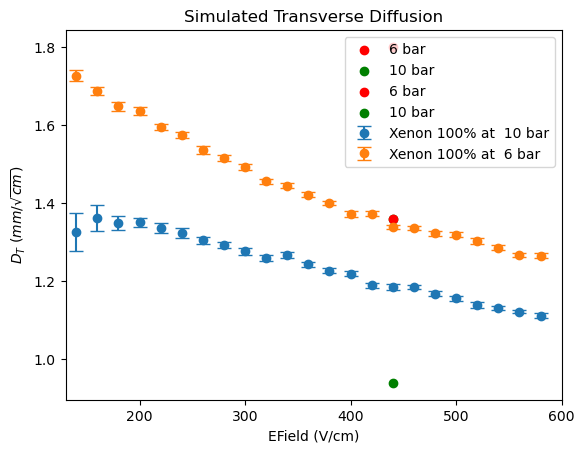

In [22]:
plt.title("Simulated Transverse Diffusion")
plt.xlabel("EField (V/cm)")
plt.ylabel("$D_{T}$ " + r'($mm/\sqrt{cm}$)')
#plt.axvline(440,0,color="r")
#plt.xlim(0,50)
Pbar=10
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DT1"][0]/1000,yerr=Xenon100[Pbar]["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DT1"][0]/1000,yerr=Xenon99_5[Pbar]["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
Pbar=6
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DT1"][0]/1000,yerr=Xenon100[Pbar]["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DT1"][0]/1000,yerr=Xenon99_5[Pbar]["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_9["Efields"],Xenon99_9["DT1"][0]/1000,yerr=Xenon99_9["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.9%, CH4 0.1%")
plt.scatter([440],[1.8],label="6 bar",color="r")
plt.scatter([440],[1.36],label="10 bar",color="g")

plt.scatter([440],[1.36],label="6 bar",color="r")
plt.scatter([440],[0.94],label="10 bar",color="g")
plt.xlim(130,600)
plt.legend()
plt.show()

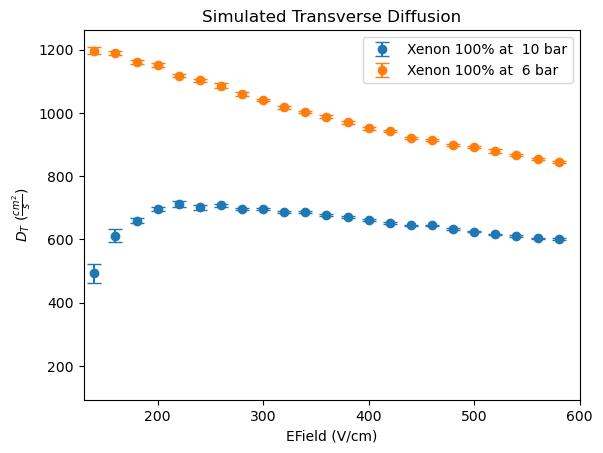

In [20]:
plt.title("Simulated Transverse Diffusion")
plt.xlabel("EField (V/cm)")
plt.ylabel("$D_{T}$ " + r'($\frac{cm^2}{s}$)')
#plt.axvline(440,0,color="r")
#plt.xlim(0,50)
Pbar=10
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DT"][0],yerr=Xenon100[Pbar]["DT"][1],capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DT1"][0]/1000,yerr=Xenon99_5[Pbar]["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
Pbar=6
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DT"][0],yerr=Xenon100[Pbar]["DT"][1],capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DT1"][0]/1000,yerr=Xenon99_5[Pbar]["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_9["Efields"],Xenon99_9["DT1"][0]/1000,yerr=Xenon99_9["DT1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.9%, CH4 0.1%")
#plt.scatter([440],[1.8],label="6 bar",color="r")
#plt.scatter([440],[1.36],label="10 bar",color="g")

plt.xlim(130,600)
plt.legend()
plt.show()

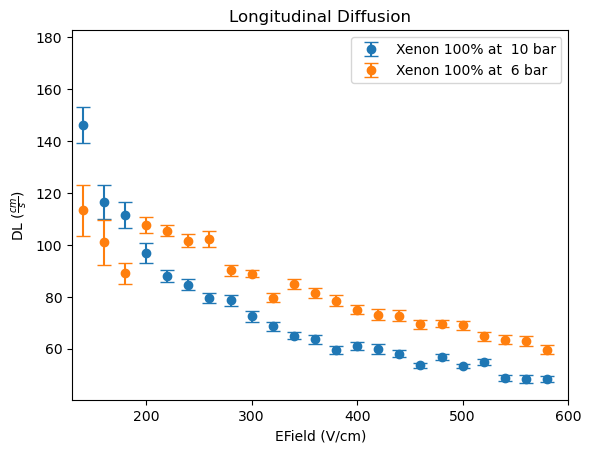

In [21]:

plt.title("Longitudinal Diffusion")
#plt.xlabel("EField " + r'\frac{$V$}{($cm$\cdot$bar$)}')
plt.xlabel("EField (V/cm)")
plt.ylabel("DL "+ r'($\frac{cm}{s}$)')
#plt.axvline(440,0,color="r")
plt.xlim(130,600)

#plt.xlim(0,50)
#plt.errorbar(Xenon100["Efields"],Xenon100["DL1"][0]/1000,yerr=Xenon100["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 100%")
#plt.errorbar(Xenon99_5["Efields"],Xenon99_5["DL1"][0]/1000,yerr=Xenon99_5["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5%")
#plt.errorbar(Xenon99_9["Efields"],Xenon99_9["DL1"][0]/1000,yerr=Xenon99_9["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.9%, CH4 0.1%")

Pbar=10
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DL"][0],yerr=Xenon100[Pbar]["DL"][1],capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DL1"][0]/1000,yerr=Xenon99_5[Pbar]["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
Pbar=6
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DL"][0],yerr=Xenon100[Pbar]["DL"][1],capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
#plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DL1"][0]/1000,yerr=Xenon99_5[Pbar]["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
plt.legend()
plt.show()

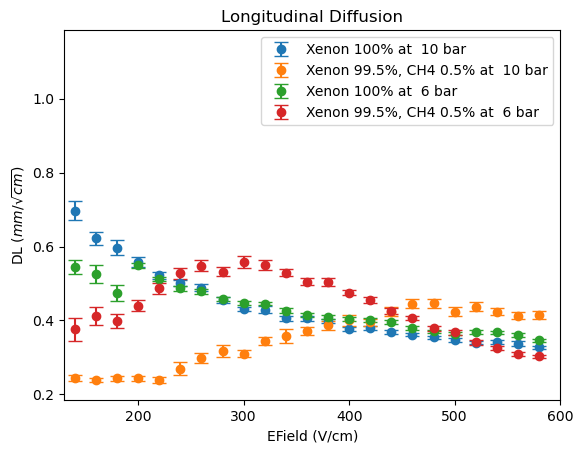

In [12]:

plt.title("Longitudinal Diffusion")
#plt.xlabel("EField " + r'\frac{$V$}{($cm$\cdot$bar$)}')
plt.xlabel("EField (V/cm)")
plt.ylabel("DL "+ r'($mm/\sqrt{cm}$)')
#plt.axvline(440,0,color="r")
plt.xlim(130,600)

#plt.xlim(0,50)
#plt.errorbar(Xenon100["Efields"],Xenon100["DL1"][0]/1000,yerr=Xenon100["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 100%")
#plt.errorbar(Xenon99_5["Efields"],Xenon99_5["DL1"][0]/1000,yerr=Xenon99_5["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5%")
#plt.errorbar(Xenon99_9["Efields"],Xenon99_9["DL1"][0]/1000,yerr=Xenon99_9["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.9%, CH4 0.1%")

Pbar=10
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DL1"][0]/1000,yerr=Xenon100[Pbar]["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DL1"][0]/1000,yerr=Xenon99_5[Pbar]["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
Pbar=6
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["DL1"][0]/1000,yerr=Xenon100[Pbar]["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["DL1"][0]/1000,yerr=Xenon99_5[Pbar]["DL1"][1]/1000,capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
plt.legend()
plt.show()

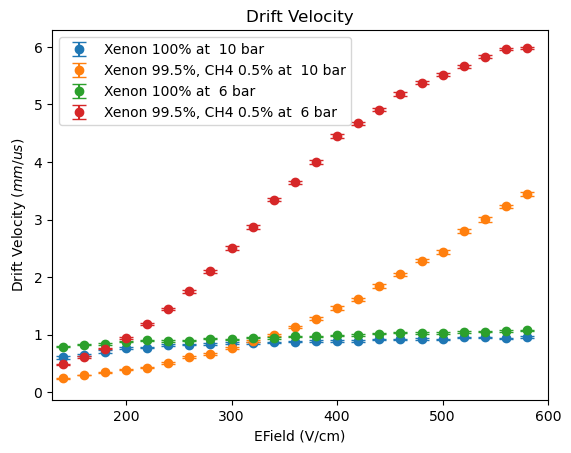

In [13]:

plt.title("Drift Velocity")
plt.xlabel("EField (V/cm)")
plt.ylabel("Drift Velocity "+ r'($mm/us$)')
plt.xlim(130,600)

#plt.xlim(0,50)
#plt.errorbar(Xenon100["Efields"],Xenon100["Drift_vel"][0],yerr=Xenon100["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 100%")

#plt.errorbar(Xenon99_5["Efields"],Xenon99_5["Drift_vel"][0],yerr=Xenon99_5["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5%")
#plt.errorbar(Xenon99_9["Efields"],Xenon99_9["Drift_vel"][0],yerr=Xenon99_9["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 99.9%, CH4 0.1%")


Pbar=10
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["Drift_vel"][0],yerr=Xenon100[Pbar]["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["Drift_vel"][0],yerr=Xenon99_5[Pbar]["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
Pbar=6
plt.errorbar(Xenon100[Pbar]["Efields"],Xenon100[Pbar]["Drift_vel"][0],yerr=Xenon100[Pbar]["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 100% at "+f" {Pbar} bar")
plt.errorbar(Xenon99_5[Pbar]["Efields"],Xenon99_5[Pbar]["Drift_vel"][0],yerr=Xenon99_5[Pbar]["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 99.5%, CH4 0.5% at "+f" {Pbar} bar")
plt.legend()
#plt.axvline(440/10,0,color="r")
plt.legend()
plt.show()